In [44]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as st
# import pymc3 as pm
import seaborn as sns
import wtascripts.wta_helpers as wta_helpers

# enables inline plots, without it plots don't show up in the notebook
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
# %config InlineBackend.figure_format = 'png'
# mpl.rcParams['figure.dpi']= 300

# import warnings
# warnings.simplefilter('ignore')

In [73]:
# Sklearn specific imports
from sklearn.preprocessing import StandardScaler, LabelBinarizer, MultiLabelBinarizer, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn import metrics
from sklearn.metrics import mean_squared_error

In [46]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 25)
pd.set_option('display.precision', 3)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
np.set_printoptions(suppress=True)

In [47]:
# Load then clean dataset
df = wta_helpers.load_raw_df()
df = wta_helpers.clean_raw_df(df)


## Helper Functions

In [248]:
def residual_plot(y_pred, y_train=y_train):
    res = y_train - y_pred
    plt.scatter(y_pred, res)
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    return plt.show();

## Plan of Action
* Use multi-label binarizer :  fee column
* Use label binarizer : region
* Probably remove votes or countreports due to collinearity. Which one is better? I think votes is bad too due to direct tie to trail
  * A better model wouldn't have votes or count of reports - because those are not trail features

#### Questions/ Flaws:
* With MLB I'm not accounting for parks that have multiple fees . I could simplify by saying fee or no fee? 

### Preprocessing

In [118]:
onehot_feats = ['Wildflowers/Meadows', 'Ridges/passes',
'Wildlife','Waterfalls','Old growth','Summits','Good for kids','Dogs allowed on leash',
'Fall foliage','Lakes','Rivers','Coast','Mountain views','Established campsites',]
# Not used: lat, long, subregion, lengthtype

# cont_feats = ['votes', 'countreports', 'length', 'gain', 'hpoint']
cont_feats = ['votes', 'length', 'gain', 'hpoint']
# cont_feats = ['length', 'gain', 'hpoint']

oh_cols = df[onehot_feats]

#Standardize the non one-hot encoding variables into XS
s = StandardScaler()
XS = s.fit_transform(df[cont_feats])
#print(oh_cols)
# combine with the one hot encoding variables

# multilabelbinarizer for 'fees' column
mlb = MultiLabelBinarizer()
fees_processed = mlb.fit_transform(df['fee'].str.replace(", ",",").str.split(","))

# labelbinarizer for 'region' column
lb = LabelBinarizer()
region_processed = lb.fit_transform(df['region'])

X = np.concatenate([XS, oh_cols, fees_processed, region_processed], axis=1) ## All features
# X = np.concatenate([oh_cols, fees_processed, region_processed], axis=1) ## Remove continuous features
# X = np.concatenate([XS], axis=1) ## Only continuous features

y = df['rating']

# Test Train Split

In [151]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Linear Regression

In [158]:
lr = LinearRegression()
lr.fit(X_train, y_train)

print("intercept:",lr.intercept_)
# print("coefficients,",lr.coef_)

print("Train RMSE:", np.sqrt(mean_squared_error(y_train, lr.predict(X_train))))
print("Train MSE:", metrics.mean_squared_error(y_train, lr.predict(X_train)))
print("Train R^2:", lr.score(X_train, y_train))
print("")

##### Save these for final model evaluation!
# print("Test RMSE:", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
# print("Test MSE:", metrics.mean_squared_error(y_test, y_pred))
# print('Test R^2: ', est.score(X_test, y_test))
# print('Test SSE:', mean_squared_error(y_test, lr.predict(X_test)))

print("")

#coefs_list = cont_feats + onehot_feats + list(mlb.classes_) + list(lb.classes_) ## Everything
# newlist = onehot_feats + list(mlb.classes_) + list(lb.classes_) ## remove continuous features
# newlist = cont_feats ## only continuous features
#pprint.pprint(sorted(zip(coefs_list, np.round(lr.coef_,3)), key=lambda x: x[1], reverse=True))

intercept: 3.1235740268008696
Train RMSE: 0.6580246341776472
Train MSE: 0.4329964191846265
Train R^2: 0.16283071693926676




In [212]:
"""Polynomial with LinearRegression"""

poly_lr = make_pipeline(PolynomialFeatures(2), LinearRegression())
poly_lr.fit(X_train, y_train)

# print("intercept:",poly_lr.intercept_)
# print("coefficients,",poly_lr.coef_)

print("Train RMSE:", np.sqrt(mean_squared_error(y_train, poly_lr.predict(X_train))))
print("Train MSE:", metrics.mean_squared_error(y_train, poly_lr.predict(X_train)))
print("Train R^2:", poly_lr.score(X_train, y_train))
print("")

##### Save these for final model evaluation!
# print("Test RMSE:", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
# print("Test MSE:", metrics.mean_squared_error(y_test, y_pred))
# print('Test R^2: ', est.score(X_test, y_test))
# print('Test SSE:', mean_squared_error(y_test, poly_lr.predict(X_test)))

print("")

#coefs_list = cont_feats + onehot_feats + list(mlb.classes_) + list(lb.classes_) ## Everything
# newlist = onehot_feats + list(mlb.classes_) + list(lb.classes_) ## remove continuous features
# newlist = cont_feats ## only continuous features
#pprint.pprint(sorted(zip(coefs_list, np.round(poly_lr.coef_,3)), key=lambda x: x[1], reverse=True))

Train RMSE: 0.44843909095696516
Train MSE: 0.20109761829830927
Train R^2: 0.6111913598430194




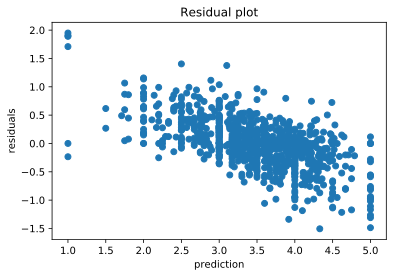

In [249]:
# plot of poly_lr
residual_plot(y_train, poly_lr.predict(X_train))

#### Tips from Chad on what I can do now:
* Plot whatever feats I want to explore vs residuals
* Look for patterns in data
* If I am missing data in a certain area of my predicted vs actual plots, then take subset and look there
* plot sum /log / function of the categorical features, vs residuals.

##### Once I find a pattern and want to Feat Eng., then add a new column to my X data array.

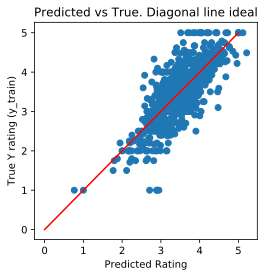

In [250]:
plt.figure(figsize=(4,4))
plt.scatter(poly_lr.predict(X_train), y_train)
plt.xlabel("Predicted Rating")
plt.ylabel("True Y rating (y_train)")
plt.title("Predicted vs True. Diagonal line ideal")
plt.plot(range(6), c='r');

# Lasso

In [224]:
#alphas = [1e-14,1e-10,1e-6,1e-3,1e-2,1e-1,1,10,100]
lasso = LassoCV()
lasso.fit(X_train, y_train)
print("intercept:",lasso.intercept_)
# print("coefficients,",lasso.coef_)

print("Train RMSE:", np.sqrt(mean_squared_error(y_train, lasso.predict(X_train))))
print("Train MSE:", metrics.mean_squared_error(y_train, lasso.predict(X_train)))
print("Train R^2:", lasso.score(X_train, y_train))
print("")

##### Save these for final model evaluation!
# print("Test RMSE:", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
# print("Test MSE:", metrics.mean_squared_error(y_test, y_pred))
# print('Test R^2: ', est.score(X_test, y_test))
# print('Test SSE:', mean_squared_error(y_test, lasso.predict(X_test)))

print("")

#coefs_list = cont_feats + onehot_feats + list(mlb.classes_) + list(lb.classes_) ## Everything
# newlist = onehot_feats + list(mlb.classes_) + list(lb.classes_) ## remove continuous features
# newlist = cont_feats ## only continuous features
#pprint.pprint(sorted(zip(coefs_list, np.round(lasso.coef_,3)), key=lambda x: x[1], reverse=True))

intercept: 3.3164469355553905
Train RMSE: 0.670378463759675
Train MSE: 0.44940728467278185
Train R^2: 0.1311014187593964




In [222]:
"""Polynomial with LassoCV"""

#alphas = [1e-14,1e-10,1e-6,1e-3,1e-2,1e-1,1,100]
poly_lasso = make_pipeline(PolynomialFeatures(2), LassoCV())
poly_lasso.fit(X_train, y_train)
#print("intercept:",poly_lasso.intercept_)
# print("coefficients,",poly_lasso.coef_)

print("Train RMSE:", np.sqrt(mean_squared_error(y_train, poly_lasso.predict(X_train))))
print("Train MSE:", metrics.mean_squared_error(y_train, poly_lasso.predict(X_train)))
print("Train R^2:", poly_lasso.score(X_train, y_train))
print("")

##### Save these for final model evaluation!
# print("Test RMSE:", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
# print("Test MSE:", metrics.mean_squared_error(y_test, y_pred))
# print('Test R^2: ', est.score(X_test, y_test))
# print('Test SSE:', mean_squared_error(y_test, poly_lasso.predict(X_test)))

print("")

#coefs_list = cont_feats + onehot_feats + list(mlb.classes_) + list(lb.classes_) ## Everything
# newlist = onehot_feats + list(mlb.classes_) + list(lb.classes_) ## remove continuous features
# newlist = cont_feats ## only continuous features
#pprint.pprint(sorted(zip(coefs_list, np.round(poly_lasso.coef_,3)), key=lambda x: x[1], reverse=True))

Train RMSE: 0.6547261063820075
Train MSE: 0.4286662743781437
Train R^2: 0.17120275897605475




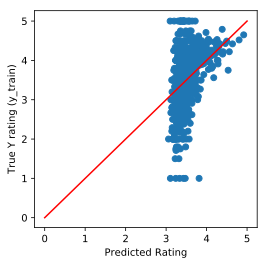

In [232]:
plt.figure(figsize=(4,4))
plt.scatter(poly_lasso.predict(X_train), y_train)
plt.xlabel("Predicted Rating")
plt.ylabel("True Y rating (y_train)")
plt.plot(range(6), c='r');

# Ridge Regression

In [223]:
#Straight Ridge Regression

#alphas = [1e-14,1e-10,1e-6,1e-3,1e-2,1e-1,1,100]
ridge = RidgeCV()
ridge.fit(X_train, y_train)
print("intercept:",ridge.intercept_)
# print("coefficients,",ridge.coef_)

print("Train RMSE:", np.sqrt(mean_squared_error(y_train, ridge.predict(X_train))))
print("Train MSE:", metrics.mean_squared_error(y_train, ridge.predict(X_train)))
print("Train R^2:", ridge.score(X_train, y_train))
print("")

##### Save these for final model evaluation!
# print("Test RMSE:", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
# print("Test MSE:", metrics.mean_squared_error(y_test, y_pred))
# print('Test R^2: ', est.score(X_test, y_test))
# print('Test SSE:', mean_squared_error(y_test, ridge.predict(X_test)))

print("")

#coefs_list = cont_feats + onehot_feats + list(mlb.classes_) + list(lb.classes_) ## Everything
# newlist = onehot_feats + list(mlb.classes_) + list(lb.classes_) ## remove continuous features
# newlist = cont_feats ## only continuous features
#pprint.pprint(sorted(zip(coefs_list, np.round(ridge.coef_,3)), key=lambda x: x[1], reverse=True))

intercept: 3.2434848100537117
Train RMSE: 0.6599142266599237
Train MSE: 0.43548678654816525
Train R^2: 0.15801576012226226




In [221]:
"""Polynomial with RidgeCV"""

#alphas = [1e-14,1e-10,1e-6,1e-3,1e-2,1e-1,1,100]
poly_ridge = make_pipeline(PolynomialFeatures(2), RidgeCV())
poly_ridge.fit(X_train, y_train)
#print("intercept:",poly_ridge.intercept_)
# print("coefficients,",poly_ridge.coef_)

print("Train RMSE:", np.sqrt(mean_squared_error(y_train, poly_ridge.predict(X_train))))
print("Train MSE:", metrics.mean_squared_error(y_train, poly_ridge.predict(X_train)))
print("Train R^2:", poly_ridge.score(X_train, y_train))
print("")

##### Save these for final model evaluation!
# print("Test RMSE:", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
# print("Test MSE:", metrics.mean_squared_error(y_test, y_pred))
# print('Test R^2: ', est.score(X_test, y_test))
# print('Test SSE:', mean_squared_error(y_test, poly_ridge.predict(X_test)))

print("")

#coefs_list = cont_feats + onehot_feats + list(mlb.classes_) + list(lb.classes_) ## Everything
# newlist = onehot_feats + list(mlb.classes_) + list(lb.classes_) ## remove continuous features
# newlist = cont_feats ## only continuous features
#pprint.pprint(sorted(zip(coefs_list, np.round(poly_ridge.coef_,3)), key=lambda x: x[1], reverse=True))

Train RMSE: 0.5297713163075961
Train MSE: 0.28065764758228307
Train R^2: 0.4573674256835194




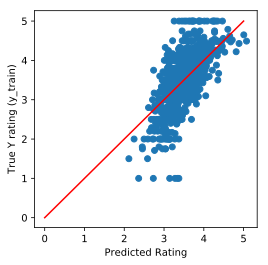

In [234]:
plt.figure(figsize=(4,4))
plt.scatter(poly_ridge.predict(X_train), y_train)
plt.xlabel("Predicted Rating")
plt.ylabel("True Y rating (y_train)")
plt.plot(range(6), c='r');

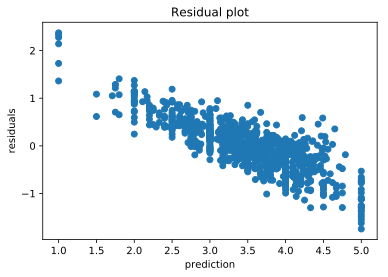

In [251]:
residual_plot(y_train, poly_ridge.predict(X_train))

# Feature Engineering and EDA

# Plots

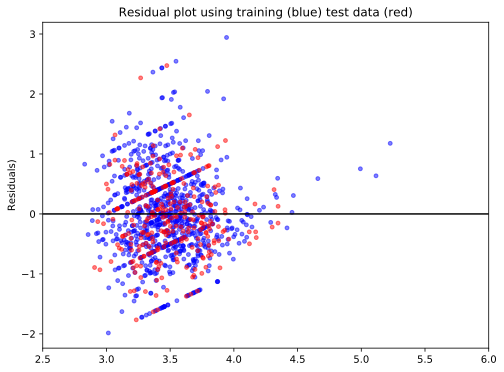

In [15]:
plt.figure(figsize = (8,6))
plt.scatter(reg.predict(X_train), reg.predict(X_train) - y_train, c='b', s=15, alpha=0.5)
plt.scatter(reg.predict(X_test), reg.predict(X_test) - y_test, c='r', s=15, alpha=0.5)
plt.hlines(y=0, xmin=0, xmax=50)
plt.xlim(2.5,6)
plt.title("Residual plot using training (blue) test data (red)")
plt.ylabel("Residuals)");

In [271]:
y2 = y[:,np.newaxis]
y2.shape

(1150, 1)

In [284]:
XSpecial = np.concatenate([X, y2], axis=1)

In [292]:
df_special = pd.DataFrame(XSpecial, columns= (cont_feats + onehot_feats + list(mlb.classes_) + list(lb.classes_) + ['rating']))

In [296]:
sns.pairplot(df_special, y_vars = 'rating', x_vars = df_special.columns[:-1]);

In [ ]:
# votes, count of tripreports, mountains, waterfall, summits, then hpoint, then ridges/passes

In [ ]:
# sns.pairplot(df[(df.votes > 3) & (df.length < 60) & (df.hpoint < 9000)],
#              x_vars=['votes','length','gain','hpoint','countreports'],
#              y_vars='rating')

In [ ]:
# # votes and count reports are highly correlated
# plt.scatter(df['votes'], df['countreports']);